# Preprocessing

**Installing any necessary dependencies**

In [ ]:
!pip -q install librosa

<br>

**Mounting google drive to the file (Only necessary if using drive and google colab)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<br>

**Defining relevant filepaths**

In [ ]:
#Filepath to the audio file to be used for training
filePathIn = '/content/drive/My Drive/Songs_For_ML_Project/Lofi.mp3'

#Filepath to the folder to save training features
featurePath = '/content/drive/My Drive/Songs_For_ML_Project/Features'


<br>

**Importing all necessary libraries**

In [ ]:
import librosa
import numpy as np
import os
import gc
import shutil


<br>

**Function to extract features from a portion of the audio file provided**


*   filePath - file path to audio file
*   offset - starting point for feature extraction (in seconds)
*   duration - duration of audio to be loaded and processed (in seconds)
*   sr - sampling rate (default is 22050Hz), the number of samples per second which the audio is loaded at. Lowering sample rate will decrease audio quality as well as memory usage.
*   n_mels - Determines the resolution of the frequency dimension of the resulting spectrogram. More Mel bands provides more detailed frequency resolution

*Returns -*  A 2D array containing a mel spectogram, with an added singleton third dimension to indicate that we are using one channel (mono) audio.

<br>

*What is a spectogram?*<br>
A spectogram is technically three dimensional. The x-axis marks time, and the y-axis marks frequency. The 3rd dimension represents the intensity of each frequency at each moment in time. This is displayed in the following spectrogram through varying colors. The way that this dimension is calculated is by applying a 'Fourier Transform' at each time sample from the file. Each one of these can be thought of as a two dimensional graph with frequency (Hz) on the x-axis and the intensity (dB) on the y-axis.

<br>

*Why a Mel Spectogram?* <br>
We are using a mel spectrogram here instead of a regular spectrogram because the mel scale transforms spectrogram data to be more easily processed by human ears. This is useful because the patterns recognized by the CNN should be pertinant to humans in order to produce a more appealing audio output.

<br>

*How is this done?* <br>
The Mel scale transforms the fourier spectogram into (here 128) zones that seem equidistant to human ears. This is done because a differenct from 500Hz to 1000Hz is easily recognizable while a change from 7500Hz to 8000Hz is not as recognizable.

<br>

Below is an image of a Mel Spectrogram

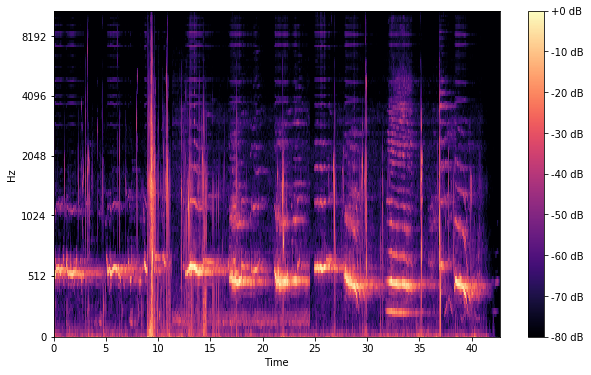

In [ ]:
def extractFeatures(filePath, offset, duration, sr = 22050, n_mels = 128):
  #Loading audio into memory. Using mono audio to simplify the processing and reduce the amount of data used
  #y is an audio time series array
  y, sr = librosa.load(filePath, sr=sr, offset=offset, duration=duration, mono=True)

  #Computing Mel-Spectrogram of the loaded audio data
  #This function computes the short-time fourier transform (STFT) to get the frequency spectrum over time and then maps the frequencies onto the mel scale
  #The number of Fourier transforms performed in 1 second is determined by the sample rate, window size, and hop length.
  #The window size is typically 2048 samples, and the hop length is typically 1024, meaning that there are 22 Fourier transforms with a sample rate of 22050
  #Increasing window size (n_fft) enhances frequency resolution but worsens time resolution
  #Decreasing hop_length enhances time resolution
  #melS is a 2D array where rows correspond to the mel bands (frequency bins on the mel scale) and the columns correspond to the time frames in the audio file.
  melS = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft = 2048, hop_length = 512, win_length = 2048)

  #Converting mels spectrogram to the decible scale, which is a log scale of the power of each frequency band
  #This step reduces the dynamic range of the audio, making patterns more discernable for the neural network
  #melS_dB is just melS but with the values scaled to decibles
  melS_dB = librosa.power_to_db(melS, ref=np.max)

  #This line alters the shape of the mel spectogram to have one more dimension. This is done exclusively to abide by the specifications of tensorflow.
  #The dimensions of the model used for training are (number of Mel bands, number of frames, and number of channels)
  #Since we are using mono audio (one channel audio), this extra dimension must be added
  melS_dB = melS_dB[..., np.newaxis]

  #the shape of the returned value is (number of mel bands, number of frames, 1)
  return melS_dB


#Use this to test the shape of the returned mel spectogram
#print(extractFeatures(filePathIn, 0, 1).shape)

<br>

**Defining constant segment duration and calculating the shape of the mel spectogram features**

<br>

This is done to keep the shape of the features consistent, as this will be important later on while building the model. We will save the shape of the mel spectogram now to be used later in the model building phase.

In [ ]:
segmentDuration = 15
inputShape = extractFeatures(filePathIn, 0, segmentDuration).shape
print(inputShape)


(128, 646, 1)


<br>

**Function to process a large audio file in chunks**


*   filePath - file path to the input mp3
*   segmentDuration - Duration of time segment to have features extracted (in seconds)
*   saveDir - file path to directory used to save the all feature files

*Returns -* Nothing, this function populates a directory with files contianing mel spectograms indexed by their offset

<br>

*What is being done here?* <br>
First, the directory of features is deleted along with all of its contents. This is done to remove previous features and keep the training phase integral to the current data. The directory is then recreated (and is now empty). Then the function sends the start position (offset) and the duration of the chunk of audio to get its features extracted. The resulting mel spectogram is then saved in featurePath as its own file. The returned mel spectogram is then deleted to conserve memory. This is done incrementally for the entire duration of the input file.



In [ ]:
def processLargeAudioFile(filePath = filePathIn, segmentDuration = segmentDuration, saveDir = featurePath):
  #Deleting the feature directory and all of its contents to remove any previous feature data
  #ignore_errors is True to ignore the error that occurs if the feature directory doesn't exist
  #This is to ensure that there is a blank directory to fill with features relating to this data
  shutil.rmtree(featurePath, ignore_errors = True)

  #Checking for the existance of feature directory, creates the folder if not.
  os.makedirs(saveDir, exist_ok=True)

  #Get total duration of the audio file
  totalDuration = librosa.get_duration(path = filePath)

  print(f"Total Duration of Audio in seconds:  {totalDuration}")

  #Process in chunks
  for start in np.arange(0, totalDuration, segmentDuration):
      print(f"Processing segment starting at {start} seconds.")
      # Extract features
      features = extractFeatures(filePath, offset=start, duration=segmentDuration)

      # Save the extracted features
      featureFile = os.path.join(saveDir, f'features_{int(start)}.npy')
      np.save(featureFile, features)

      # Free up memory
      del features
      gc.collect()

      print(f"Saved {featureFile}")


In [ ]:
#This is commennted out because it takes around 10 minutes to preprocess 600 megabyte audio file
processLargeAudioFile()

Total Duration of Audio in seconds:  36990.016
Processing segment starting at 0.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_0.npy
Processing segment starting at 15.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_15.npy
Processing segment starting at 30.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_30.npy
Processing segment starting at 45.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_45.npy
Processing segment starting at 60.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_60.npy
Processing segment starting at 75.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_75.npy
Processing segment starting at 90.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_90.npy
Processing segment starting at 105.0 seconds.
Saved /content/drive/My Drive/Songs_For_ML_Project/Features/fe

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=353
  warnings.warn(


Saved /content/drive/My Drive/Songs_For_ML_Project/Features/features_36990.npy


<br>

**Confirming Homogeneity of features**

Several features within the features directory have the potential to not conform to the standardized input shape. This function removes those files, thus ensuring the homogeneity of all features.

In [ ]:
def cleanHomogeneity(dataDir):
    shapes = set()
    files = os.listdir(dataDir)
    for file in files:
        dataPath = os.path.join(dataDir, file)
        data = np.load(dataPath)
        print(f"file {file} and the shape {data.shape}")
        shapes.add(data.shape)
        if data.shape != inputShape:
          print(f"file {file} is being removed because it has shape {data.shape}")
          os.remove(dataPath)
    print("Data shapes found:", shapes)


In [ ]:
cleanHomogeneity(featurePath)

file features_0.npy and the shape (128, 646, 1)
file features_15.npy and the shape (128, 646, 1)
file features_30.npy and the shape (128, 646, 1)
file features_45.npy and the shape (128, 646, 1)
file features_60.npy and the shape (128, 646, 1)
file features_75.npy and the shape (128, 646, 1)
file features_90.npy and the shape (128, 646, 1)
file features_105.npy and the shape (128, 646, 1)
file features_120.npy and the shape (128, 646, 1)
file features_135.npy and the shape (128, 646, 1)
file features_150.npy and the shape (128, 646, 1)
file features_165.npy and the shape (128, 646, 1)
file features_180.npy and the shape (128, 646, 1)
file features_195.npy and the shape (128, 646, 1)
file features_210.npy and the shape (128, 646, 1)
file features_225.npy and the shape (128, 646, 1)
file features_240.npy and the shape (128, 646, 1)
file features_255.npy and the shape (128, 646, 1)
file features_270.npy and the shape (128, 646, 1)
file features_285.npy and the shape (128, 646, 1)
file fea

<br>

**Function to split the features into testing and training directories**

*   sourceDir - the file path directory containing all of the features from the preprocessing
*   trainDir - the file path of the directory to store the training features
*   testDir - the file path of the directory to store the testing features
*   testSize - percentage of files to be designated as testing data. (Note: (1 - testSize) is gives the percentage of files to be used as training data)

*Returns* - Nothing, this function simply deletes and then creates two directories to split the data into training and testing categories. By default, 20% of the data will be reserved for testing.

In [ ]:
def splitData(sourceDir, trainDir, testDir, testSize = 0.2):
  #Delete previous training and testing directories
  shutil.rmtree(trainDir, ignore_errors = True)
  shutil.rmtree(testDir, ignore_errors = True)

  #Create train and test directories
  os.makedirs(trainDir, exist_ok=True)
  os.makedirs(testDir, exist_ok=True)

  #Get all file names from the source directory
  allFiles = os.listdir(sourceDir)
  #Due to the nature of the data (music), it may be better to keep the music unshuffled because of continuity
  #np.random.shuffle(allFiles)

  #Calculate the index at which to split the data
  splitIndex = int(len(allFiles) * (1 - testSize))

  #Split files into training and testing
  trainFiles = allFiles[:splitIndex]
  testFiles = allFiles[splitIndex:]

  # Move files to respective directories
  for file in trainFiles:
      shutil.move(os.path.join(sourceDir, file), os.path.join(trainDir, file))

  for file in testFiles:
      shutil.move(os.path.join(sourceDir, file), os.path.join(testDir, file))


<br>

**Defining testing and training repositories and splitting the data**

By default, the directories will be stored inside of a new directory called FeaturesSplit.

In [ ]:
#Directory to store test and train directories
splitFeaturesDirectory = '/content/drive/My Drive/Songs_For_ML_Project/FeaturesSplit'
os.makedirs(splitFeaturesDirectory, exist_ok=True)

#Training and testing directories defined
trainDirectory = '/content/drive/My Drive/Songs_For_ML_Project/FeaturesSplit/train'
testDirectory = '/content/drive/My Drive/Songs_For_ML_Project/FeaturesSplit/test'

#Calling split function
splitData(featurePath, trainDirectory, testDirectory, testSize = 0.2)


<br>

**Function to create generators to generate data in batches in order to save memory during fitting process**

*   dataDir - directory containing either training or testing features
*   batchSize - number of features to be pulled at a time

*Returns -* a generator that is linked to a certain directory (training or testing) along with a batch size

<br>

*What the generator actually does* <br>
The generator will produce batches of ordered features and batches of the next feature in sequence. This is done for predictive purposes: by giving the features with the label being the next feature in sequence, the model will gain predictive capabilities. For this reason, we will need to keep all of the data sorted. We are doing this in batches in order to avoid overloading the system memory while trying to load all of our data at once.


In [ ]:
def dataGenerator(dataDir, batchSize):
  #Load all of the files
  files = os.listdir(dataDir)
  #Shuffling has not been confirmed to benefit the model
  #np.random.shuffle(files)

  while True:
    np.random.shuffle(files)
    #define empty array to store features
    featuresBatch = []
    #This is the label representing the next feature in sequence
    nextFeaturesBatch = []

    for i in range(len(files) - 1):

      #Define filepath for current feature and next feature
      currentPath = os.path.join(dataDir, files[i])
      nextPath = os.path.join(dataDir, files[i + 1])

      #Load the current and next features
      currentFeature = np.load(currentPath)
      nextFeature = np.load(nextPath)

      #add current feature to the batch
      featuresBatch.append(currentFeature)
      nextFeaturesBatch.append(nextFeature)

      if len(featuresBatch) == batchSize:
        #if we have reached the batch size, we will yield the current batches and then empty the arrays
        yield (np.array(featuresBatch), np.array(nextFeaturesBatch))
        featuresBatch = []
        nextFeaturesBatch = []

    #if the for loop ends and there is still information in the batch, that means we have a partially full batch remaining
    if featuresBatch:
      yield (np.array(featuresBatch), np.array(nextFeaturesBatch))
      featuresBatch = []
      nextFeaturesBatch = []


<br>

**Defining the generators for testing and training**

Here, we define the batch size and then the generators to be used in training and testing. If memory problems occur, try decreasing the batch size.

In [ ]:
#Batch size to be used for testing and training
batchSize = 20

#Defining the generators
trainGen = dataGenerator(trainDirectory, batchSize)
testGen = dataGenerator(testDirectory, batchSize)

<br>

**Determining the number of features to be used for output layer**


The number of features is the same for the testing and training data.

In [ ]:
# Load a single sample
sampleFile = os.listdir(testDirectory)[0]
samplePath = os.path.join(testDirectory, sampleFile)
sampleData = np.load(samplePath)

# Determine the number of features
numFeatures = np.prod(sampleData.shape)  # Product of dimensions if multi-dimensional, simple length if 1D

print("Number of features:", numFeatures)

Number of features: 82688


# Designing the Model

The model that we will be using is a convolutional neural network, with tensorflow as our primary technology.

<br>

**Importing Necessary Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

<br>

**Function to build our model**

<br>

*Conv2D* <br>

These are convolutional layers that help the model learn features from the spectogram inputs.

*   First Argument (int)  - this is the number of filters/kernels to be used by the convolutional layer. Each filter extracts different features from the input. More filters allows the network to capture more complex features
*   Second Argument ((int, int)) - This specifies the dimensions of the filters used in the convolution. Can be altered to capture fine details (small filters) or broad details (large filters)
*   activation - the activation function. We will be using ReLU, or 'Rectified Linear Unit'. The input will be outputted directly if the input value is positive, and will output zero if the input value is negative. This is used to introduce nonlinearity in a neural network, allowing the NN to learn more complex relationships in the data. ReLU is considered the best activation function for deep learning.
*   input_shape - describes the input shape of the function. This is only required for the first layer. The purpose is to inform the layer about how the data will be structured.

<br>

*BatchNormalization* <br>
This layer normalizes the activations from the previous later, which helps to increase the speed of training, and can lead to faster convergence. It does this by applying a transformation that maintains a mean of 0 and a standard deviation of 1.

<br>

*MaxPooling2D* <br>
This layer reduces the dimensions of the inputs for the next convolutional layer. This helps with memory usage, computational load, and reducing the number of parameters. This is done by taking the maximum value within a pooling window. This is done for every window in the input.
*   First Argument ((int, int)) - This is the pooling window

<br>

*Dropout* <br>
This layer drops a fraction of the inputs (by setting their weights to zero). This is done to reduce overfitting by forcing the network not to rely on any one feature.
*   First Argument (float) - Fraction of inputs to be dropped.

<br>

*Flatten* <br>
This layer converts the multi-dimensional output of the previous layer to a one-dimensional array. This is necessary because fully connected layers require input in one-dimensional form.

<br>

*Dense* <br>
This is a fully connected layer where every input is connected to every output by a learned weight.
*   First Argument (int) - The number of neurons in the dense layer. Each neuron will learn to detect specific features from the flattened input it recieves.
*   activation - again, we will be using ReLU as the activation function since it is considered the best for deep learning. For the output layer, we will be using softmax, which is used to normalize the output of a network to a probabiluty distribution over the predicted output classes. This is ideal for multi-class classification problems with mutually exclusive outputs.

<br>



<br>

**Compiling the model**

*   optimizer - The optimizer is the algorithm used to change the attributes of the neural network in order to minimize loss. Adam is an algorithm that can handle sparse gradients on noisy problems, and is very popular for deep learning.
*   loss - The loss function that will be minimized through training. This measures the difference between the output probabilities and the target value. Categorical_crossentropy is used for multiclass classification. If the labels are integers, use spacial_categorical_crossentropy.
*   metrics - Metrics used to evaluate the performance of the model during training and testing. Accuracy calculates how often the predictions are equal to labels.

<br>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D

model2 = Sequential([
    # Encoder
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=inputShape), #(128, 1292, 1)
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    # Decoder
    Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same', input_shape = inputShape),
    Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same' ),
    Cropping2D(cropping=((0, 0), (1, 1))),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # output layer with same channel count as input
])

model2.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])  # mse is typical for reconstruction

<br>

**Fitting the model**

IMPORTANT: We will be fitting the model using generators that were defined in the preprocessing section. Make sure to run the entire preprocessing section prior to fitting.

*Understanding what is being used while fitting* <br>
*   Batch Size - this is the number of samples processed before the model is updated.
*   Steps Per Epoch - Defines how many batches of samples are processed before a single epoch is considered finished. If a dataset has 1000 samples and a batch size of 100, there will be 10 steps to finish one epoch.
*   Epoch - One full cycle through the training data. Each sample has been passed forward and backward through the neural network once.

In [ ]:
numTrainingFeatures = len(os.listdir(trainDirectory))
numTestingFeatures = len(os.listdir(testDirectory))

model2.fit(
    trainGen,
    steps_per_epoch=numTrainingFeatures // batchSize,
    validation_data=testGen,
    validation_steps=numTestingFeatures // batchSize,
    epochs=10
)

Epoch 1/10
98/98 [==============================] - 857s 9s/step - loss: 2640.3198 - accuracy: 8.7278e-06 - val_loss: 2654.4573 - val_accuracy: 8.7175e-06
Epoch 2/10
98/98 [==============================] - 817s 8s/step - loss: 2647.0125 - accuracy: 8.7712e-06 - val_loss: 2648.3684 - val_accuracy: 8.8465e-06
Epoch 3/10
98/98 [==============================] - 856s 9s/step - loss: 2640.3506 - accuracy: 8.7216e-06 - val_loss: 2640.7695 - val_accuracy: 8.6931e-06
Epoch 4/10
98/98 [==============================] - 847s 9s/step - loss: 2639.3381 - accuracy: 8.7650e-06 - val_loss: 2659.4980 - val_accuracy: 8.7442e-06
Epoch 5/10
98/98 [==============================] - 838s 9s/step - loss: 2647.6765 - accuracy: 8.7526e-06 - val_loss: 2650.5930 - val_accuracy: 8.5908e-06
Epoch 6/10
98/98 [==============================] - 846s 9s/step - loss: 2641.0803 - accuracy: 8.7464e-06 - val_loss: 2645.0603 - val_accuracy: 8.8721e-06
Epoch 7/10
98/98 [==============================] - 840s 9s/step - los

**Attempt at generation**

This is an attempt at feature generation, though conversion of features has not yet been attempted.

In [ ]:
# Assuming 'data_samples' is a batch of your data
data_samples = extractFeatures(filePathIn, 0, segmentDuration)
print(data_samples.shape)
data_samples = data_samples.reshape(-1, 128, 216, 1)

# Predict using the model
predicted_outputs = model2.predict(data_samples)
print("Predicted Outputs for Batch:", predicted_outputs)


(128, 216, 1)
1/1 [==============================] - 0s 161ms/step
Predicted Outputs for Batch: [[[[3.10052073e-09]
   [5.59607291e-11]
   [1.74143668e-11]
   ...
   [1.51873427e-11]
   [4.65840977e-10]
   [1.14345816e-07]]

  [[4.80350785e-13]
   [5.40961353e-14]
   [1.00531447e-19]
   ...
   [3.43091576e-13]
   [6.45867757e-16]
   [1.78691039e-06]]

  [[6.64054714e-11]
   [8.10741887e-18]
   [1.72559940e-22]
   ...
   [2.79552453e-21]
   [1.39490530e-19]
   [1.85175131e-13]]

  ...

  [[1.51842762e-22]
   [2.14295384e-28]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [9.35549529e-26]]

  [[4.01849413e-15]
   [1.34201668e-24]
   [3.50597890e-32]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [1.06878908e-34]]

  [[2.34977749e-11]
   [1.14797052e-17]
   [1.15400121e-28]
   ...
   [2.41692312e-31]
   [0.00000000e+00]
   [1.29838293e-23]]]]
